# In-class exercise 8: PyTorch from the bottom up

Based on Jeremy Howard's PyTorch tutorial "What is torch.nn really?"

In this tutorial we will start at [PyTorch](https://pytorch.org/docs)'s lowest layer and then gradually introduce functions and features until we arrive at `nn.Sequential`. Lower layers give you more control over what you want to do, while higher layers allow for faster implementations. So in practice you have to choose at which layer you want to work. Moreover, knowing how the lower layers work will give you a better understanding of what is happening behind the scenes when working with the higher level abstractions.

In [1]:
import copy
import random
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

To make our code more clean and readable, we make use of **type annotations**. These are not necessary, but can be very helpful when working with Python and PyTorch. We also use the `typechecked` decorator to make sure that our code is type-checked.

In [2]:
from typing import Any, Callable, Dict, Optional, Set, Tuple, Union

from typeguard import typechecked

# Download the data
In this tutorial we will be working with the **MNIST dataset**. This is a classic dataset consisting of gray-scale images of hand-drawn digits.

We will use [torchvision](https://pytorch.org/vision/stable/index.html) to download the dataset. Torchvision also provides a lot of functionality for data preprocessing and augmentation, which is beyond the scope of this tutorial.

In [5]:
# download MNIST dataset
mnist_dev = torchvision.datasets.MNIST("./data", train=True, download=True)
mnist_test = torchvision.datasets.MNIST("./data", train=False, download=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:04<00:00, 2.02MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 255kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 859kB/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.87MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



MNIST consists of 70,000 28x28 images, each corresponding to a single digit (0 to 9), divided into 60,000 training images and 10,000 test images.

In [6]:
mnist_dev, mnist_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test)

The MNIST dataset provided by torchvision is a subclass of `torch.utils.data.Dataset`. This is a PyTorch class that allows you to easily load and process data. It is a very useful class that you will use a lot when working with PyTorch.

In [7]:
# check if the dataset is an instance of torch.utils.data.Dataset
isinstance(mnist_dev, torch.utils.data.Dataset)

True

We will see later how to properly use this class, but for now we will just use it to download the data.

The input data $\mathbf{X}$ and targets $\mathbf{y}$ are saved in `data` and `targets`, so we will at first just extract these and work with the raw data.

In [11]:
x_dev, y_dev = mnist_dev.data, mnist_dev.targets

In [13]:
print(x_dev.shape, x_dev.dtype, x_dev.min(), x_dev.max())
print(y_dev.shape, y_dev.dtype, y_dev.min(), y_dev.max())

torch.Size([60000, 28, 28]) torch.uint8 tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
torch.Size([60000]) torch.int64 tensor(0) tensor(9)


Let's have a look at the first 10 images in the dataset.

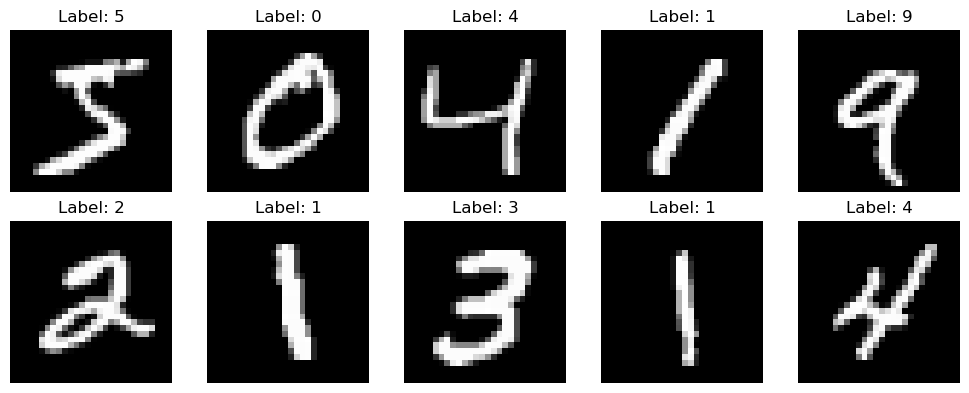

In [14]:
# plot the first 10 images
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    ax[i // 5, i % 5].imshow(x_dev[i], cmap="gray")
    ax[i // 5, i % 5].set_title(f"Label: {y_dev[i]}")
    ax[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()

We convert them to values between 0 and 1.

In [ ]:
x_dev = None  # TODO

Note that setting `train=True` gives you the development set, i.e. both training and validation data. So we need to **split** this further into a training and validation set.

In [ ]:
# split the dataset into train and validation
NUM_TRAIN = 50_000

x_train, y_train = None, None  # TODO
x_val, y_val = None, None  # TODO

Let us define the test set as well.

In [ ]:
x_test = None  # TODO
y_test = None  # TODO

Let's have a final check to sizes, dtypes, etc. of the data.

In [ ]:
# check the shapes and data types
print(
    f"Training data: {x_train.shape}, {y_train.shape}, {x_train.dtype}, {y_train.dtype}"
)
print(f"Validation data: {x_val.shape}, {y_val.shape}, {x_val.dtype}, {y_val.dtype}")
print(f"Test data: {x_test.shape}, {y_test.shape}, {x_test.dtype}, {y_test.dtype}")

We save the number of features and the number of classes in variables, so that we can use them later.

In [ ]:
# define number of features and classes
NUM_FEATURES = None  # TODO
NUM_CLASSES = None  # TODO

print(f"Num. of features: {NUM_FEATURES}")
print(f"Num. of classes: {NUM_CLASSES}")

## Reproducibility

Reproducibility is important in machine learning. If you run the same code twice, you should get the same results. This is not always the case, because of the randomness involved in the training process. For example, if you initialize the weights of a neural network randomly, you will get different results each time you run the code. This is not a problem if you only run the code once, but if you want to compare different models, you need to make sure that the results are reproducible.

In PyTorch, you can set the random seed using `torch.manual_seed()`. This will make sure that the results are reproducible. For custom operators, you might need to set python seed as well as the numpy random generator seed, using `random.seed()` and `np.random.seed()`.

However, this is not enough. You also need to make sure that the results are reproducible on the GPU. This goes beyond the scope of this tutorial, but you can find more information [here](https://pytorch.org/docs/stable/notes/randomness.html).

**TL;DR**: reproducibility is crucial, and hard to achieve (especially on the GPU). If you want to compare different models, you need to make sure that the results are reproducible.

In [ ]:
def set_seed():
    # TODO
    pass

In [ ]:
# Show how seed affects the random number generation
print(f"Seed: 42")
set_seed(42)
print(np.random.randint(0, 100, 6))
print(np.random.randint(0, 100, 6))
set_seed(42)
print(f"Seed: 42")
print(np.random.randint(0, 100, 3))
print(np.random.randint(0, 100, 3))
print(np.random.randint(0, 100, 3))
print(np.random.randint(0, 100, 3))

In [ ]:
SEED = 42
set_seed(SEED)

# torch.tensor
PyTorch uses its own `torch.tensor` datatype. This is very similar to a Numpy Array, but can also be moved to and used for calculations on a GPU, and supports storing gradient information and hence dynamic backpropagation.

The special function `requires_grad` allows us to specify whether we want to store gradient information for a tensor. This is useful when we want to use the tensor in a neural network, and we want to calculate the gradients of the loss function with respect to the tensor.

In [ ]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=False)
y = torch.tensor([4.0, 5.0, 6.0], requires_grad=False)
z = torch.tensor([7.0, 8.0, 9.0], requires_grad=True)

a = x + y
b = x + z

print(f"a.requires_grad: {a.requires_grad}")
print(f"b.requires_grad: {b.requires_grad}")

# Affine layer

We start by manually setting up an **affine layer**. 

$$
\mathbf{y} = \mathbf{W} \mathbf{x} + \mathbf{b}
$$

Let's define some weights and biases (without caring about the initialization for now). 

For this we use the `torch.empty` function, which creates an uninitialized tensor of the given size. (Note that `torch.empty` does not return an empty tensor, but an uninitialized tensor. This is a bit confusing, but it is what it is). Similarly one can use `torch.Tensor`, which is a special case of `torch.empty` (see [here](https://stackoverflow.com/questions/51129043/whats-the-difference-between-torch-tensor-vs-torch-empty-in-pytorch)).

Note that we do not want to store gradient information for the weights and biases as of now. We will do this after we have initialized them.

In [ ]:
weight = None  # TODO
bias = None  # TODO

weight, bias

We can now initialize the weights via **Xavier (Glorot) initialization**. Appending a function with `_` (e.g., `requires_grad_`) means that the function is applied in-place.

In [ ]:
def sample_from_uniform():
    # TODO
    pass


def xavier_uniform_init():
    # TODO
    pass


def zeros_init():
    # TODO
    pass

In [ ]:
# initialize weight using Glorot initialization and bias to zero
weight = None  # TODO
bias = None  # TODO

weight, bias

The weights and biases are now initialized, and they now require gradient information.

We now use these weights to create a **simple linear model** (i.e. logistic regression). 

In [ ]:
def model():
    # TODO
    pass

We furthermore define a loss (negative log-likelihood) for training and a function to obtain the prediction accuracy.



In [ ]:
def log_softmax():
    # TODO
    pass


def nll_loss():
    # TODO
    pass

We can now use our model to make predictions. Let's see how it performs without training.

In [ ]:
# make predictions and compute loss
# TODO

Let's visualize the **computational graph**. This is a very useful feature of PyTorch. It allows us to visualize the computation that is performed when we call `loss.backward()`. This is very useful when debugging your code.

In [ ]:
from torchviz import make_dot
from IPython.display import Image

logits = model(x, weight, bias)
loss = nll_loss(logits, label)
params = {"weight": weight, "bias": bias}

dot = make_dot(loss, params=params, show_attrs=True, show_saved=True)
dot.render(
    "computational_graph", directory="img", format="png"
)  # Save the graph as a PNG file

Image("img/computational_graph.png", width=600)

# Training loop

We can now define a training loop. In this loop we need to
1. Get a mini-batch of data. When using dynamic computation graphs like in PyTorch it is important to choose a batch size that is large enough to leverage your hardware properly.
2. Generate predictions with our model
3. Calculate the loss
4. Update the gradients via `loss.backward()`
5. Update the `weight` and `bias` based on the gradients (optimization)

In [ ]:
# define loss function
# TODO

# define hyperparameters
# TODO


def fit():
    # TODO
    pass

In [ ]:
# call the fit function
# TODO

Nice, it works! Wasn't this already way easier than with pure Numpy? But this is just the start. Now that we've implemented our model in the lowest level of PyTorch we can start to go up the ladder and make this even better and simpler!

# torch.nn.functional

We will start by replacing some of our hand-written functions with their professionally implemented counterparts in `torch.nn.functional`. This library contains all of the PyTorch functions (other parts contain the classes). It is commonly imported via

In [ ]:
import torch.nn.functional as F

Instead of using `log_softmax` and `neg_loglikelihood` we can instead just use `F.cross_entropy`, which combines both of these.

The loss should still be the same.

In [ ]:
criterion = nll_loss
pred = model(x_train[:BATCH_SIZE], weight, bias)
target = y_train[:BATCH_SIZE]
print(criterion(pred, target))

criterion = F.cross_entropy
pred = model(x_train[:BATCH_SIZE], weight, bias)
target = y_train[:BATCH_SIZE]
print(criterion(pred, target))

# nn.Module
Next we will use `nn.Module` and `nn.Parameter` for a clearer and more concise model definition and training loop. By subclassing `nn.Module` we obtain various convenience functions such as `.parameters()` and `.zero_grad()`.

In [ ]:
from torch import nn


class LogisticRegression:
    # TODO
    pass

Since `LogRegression` is now a class we will have to first instantiate it before using it. We can then call it as if it were a function.

In [ ]:
set_seed(SEED)
model = None  # TODO

We can now take advantage of `.parameters()` and `.zero_grad()` to make our training loop more concise.

In [ ]:
# Update fit function
def fit():
    # TODO
    pass

In [ ]:
# call the fit function

# nn.Linear

Instead of manually defining and initializing the affine layer, we can instead use the PyTorch class `nn.Linear`. PyTorch provides a wide range of predefined layers to simplify our code (and make it faster). On GitHub you will find layers for pretty much anything you might want to do.

In [ ]:
# Update the model
class LogisticRegression:
    # TODO
    pass

In [ ]:
set_seed(SEED)
model = None  # TODO
criterion = F.cross_entropy
fit()  # TODO

# torch.optim

`torch.optim` provides various optimization algorithms. Here we will continue to use simple `SGD`, but you could just as easily switch to Adam or AMSgrad. Optimizers provide `.step()` and `.zero_grad()` methods, which allows us to make the last block in our `fit` function more concise.

In [ ]:
set_seed(SEED)
model = None  # TODO
criterion = F.cross_entropy

# define the optimizer
optimizer = None  # TODO

In [ ]:
# Update the fit function
def fit():
    # TODO
    pass

In [ ]:
# call the fit function
# TODO

# Dataset
As already mentioned, `torch.utils.data.Dataset` is a very useful class that allows you to easily load and process data in PyTorch.

A Dataset only needs to provide a `__len__` (which is called by Python's `len` function) and a `__getitem__` function for indexing the dataset.

`TensorDataset` provides an easy way of converting tensors to datasets. This will make our data loading more concise, since we can handle both `x_train` and `y_train` simultaneously.

In [ ]:
from torch.utils.data import TensorDataset

# create Tensor datasets
train_dataset = None  # TODO

# check if the dataset is an instance of torch.utils.data.Dataset
isinstance(train_dataset, torch.utils.data.Dataset)

In [ ]:
# Update the fit function
def fit():
    # TODO
    pass

In [ ]:
set_seed(SEED)
model = None  # TODO
criterion = F.cross_entropy
optimizer = None  # TODO

fit()  # TODO

At the beginning of this tutorial we downloaded the MNIST dataset using `torchvision`. This is a subclass of `torch.utils.data.Dataset`. Instead of working with the raw data, we can instead use this class directly. This will make our code more concise and readable.

Let's download the data again for demonstration purposes.

In [ ]:
mnist_dev = None  # TODO
mnist_test = None  # TODO

Since `MNIST` is a subclass of `torch.utils.data.Dataset` it already provides `__len__` and `__getitem__` functions.

In [ ]:
print(len(mnist_dev))
print(mnist_dev[0])

## Transforms

The `__getitem__` method is the most important one. It is used to load and process the data. In the case of the MNIST dataset, the `__getitem__` method returns a tuple containing the image and the label of the image at the given index. 

As a `PIL` image is returned, we have to:
1. convert it to a `Tensor` (we will introduce `Tensor`s later);
2. normalize the image.

Torchvision provides a `transforms` module that contains a lot of useful functions for data preprocessing and augmentation. In this case we will use the `ToTensor` and `Normalize` functions. 

If we want to use multiple transforms, we can use the `Compose` function to combine them into a single transform.

Let's download again the MNIST dataset, but this time we will use the `transforms` module to convert the images to `Tensor`s and normalize them.

In [ ]:
mnist_dev = None  # TODO

mnist_test = None  # TODO

mnist_dev, mnist_test

In [ ]:
image, label = None  # TODO
image.shape, label

The model used so far expects a vector as input, but the images are 2D. Let's implement a custom `Transform` to flatten the images.

For this, we can use the `torch.view` function. This function allows us to reshape a `Tensor` without changing its data.

In [ ]:
# Define FlattenTransform
class FlattenTransform:
    # TODO
    pass

We can also define a transform for the targets to convert them to `Tensor`s.

In [ ]:
# Define IntToTensorTransform
class IntToTensorTransform:
    # TODO
    pass

Let's now download the MNIST dataset again, but this time we will use our custom `Transform` to flatten the images.

In [ ]:
mnist_dev = None  # TODO

mnist_test = None  # TODO

mnist_dev, mnist_test

In [ ]:
image, label = None, None  # TODO
image.shape, label

Instead of splitting the dataset into a training and validation set manually, we can use `random_split` to do this for us.

In [ ]:
mnist_train, mnist_val = None, None  # TODO
mnist_train, mnist_val

`mnist_train` and `mnist_val` are both `Subset` objects, which are subclasses of `torch.utils.data.Dataset`. They are used to select a subset of the data, and they still implement the `__getitem__` and `__len__` methods.

In [ ]:
image, label = None, None  # TODO
len(mnist_train), image.shape, label

Let's have a final check to sizes, dtypes, etc. of the data.

In [ ]:
print(
    f"Train | Num. of samples: {len(mnist_train)}, X shape: {mnist_train[0][0].shape}"
)
print(f"Val   | Num. of samples: {len(mnist_val)}, X shape: {mnist_val[0][0].shape}")
print(f"Test  | Num. of samples: {len(mnist_test)}, X shape: {mnist_test[0][0].shape}")

# DataLoader

A `DataLoader` automatically generates mini-batches for your training loop. It can run multiple workers in parallel and provides useful functionality such as data shuffling. You can create a `DataLoader` for any `Dataset`.

In [ ]:
from torch.utils.data import DataLoader

# create DataLoader
train_dataloader = None  # TODO

# check if the dataset is an instance of torch.utils.data.DataLoader
isinstance(train_dataloader, torch.utils.data.DataLoader)

Let's see how the `DataLoader` works.

In [ ]:
# iterate over the DataLoader
# TODO

Using the DataLoader makes our training loop a lot cleaner:

In [ ]:
# Update the fit function
def fit():
    # TODO
    pass

In [ ]:
set_seed(SEED)
model = None  # TODO
criterion = F.cross_entropy
optimizer = None  # TODO

fit()  # TODO

# Validation

Now that we have a training loop we can go ahead and do some real work. To avoid overfitting, enable early stopping and have some information for model development we always need a validation set.

Since the validation set does not need backpropagation we can use 2x larger batches for it. Furthermore, we should shuffle our training data to avoid correlation between batches. This is not necessary (and would waste computation time) for the validation set.

In [ ]:
dataloaders = {}
dataloaders["train"] = None  # TODO
dataloaders["val"] = None  # TODO

Note that you need to call `model.train()` before training and `model.eval()` before evaluation (inference), since some layers like dropout and batch normalization work differently in each mode.

In [ ]:
# Update the fit function
def fit():
    # TODO
    pass

In [ ]:
set_seed(SEED)
model = None  # TODO
criterion = F.cross_entropy
optimizer = None  # TODO

fit()  # TODO

What happens if we let the model train for more epochs?

In [ ]:
Image("img/validation_curves_shuffle.png")

In [ ]:
Image("img/validation_curves_no_shuffle.png")

Before we continue, let's make our training loop a bit more concise.

In [ ]:
# Define run_epoch function
def run_epoch():
    # TODO
    pass

In [ ]:
# Update the fit function
def fit():
    # TODO
    pass

In [ ]:
set_seed(SEED)
model = None  # TODO
criterion = F.cross_entropy
optimizer = None  # TODO

fit()  # TODO

# Testing

Now that we have a trained model we can use it to make predictions on the test set. We can then use these predictions to calculate the accuracy on the test set.

In [ ]:
test_dataloader = None  # TODO

In [ ]:
test_loss, test_acc = run_epoch()  # TODO
print(f"Test - loss: {test_loss:.4f}, acc: {test_acc:.4f}")

# CNN
Using simple logistic regression (or an MLP) for images basically ignores the data's underlying structure. We can do much better than this by switching to a CNN. Since our training loop does not assume anything about the model we can train a CNN without any changes.

Our CNN will consist of 3 convolutional layers, each using PyTorch's predefined `Conv2d` layer. At the End, we perform average pooling. Since `Conv2d` assumes a shape of `[batch_size, num_channels, height, width]` we need to reshape our input inside the model via `.view(_)`.

In [ ]:
# Define the CNN model
class CNN:
    # TODO
    pass

We will now furthermore use momentum in our optimizer to speed up training.

In [ ]:
NUM_CHANNELS = 16
LEARNING_RATE = 0.1
MOMENTUM = 0.9

set_seed(SEED)
model = None  # TODO
criterion = F.cross_entropy
optimizer = None  # TODO

fit()  # TODO

In [ ]:
run_epoch()  # TODO

# GPUs

PyTorch can run significantly faster on a GPU than on a CPU, so you should always try to leverage that hardware. To do so, you need to move both your model and your data to the device.

So let's first check if you have a GPU and choose the appropriate device.

**Note**: If you are using Google Colab, you can go to `Runtime -> Change runtime type` and select `GPU` as hardware accelerator.

In [ ]:
# check if GPU is available
# TODO

# set the device to GPU if available
device = None  # TODO

Now, we can move our model to the device.

In [ ]:
# check model device
# TODO

# move the model to the device
# TODO

# check model device
# TODO

Then, we redefine the DataLoader to:
1. **pin the memory**: this is a trick that will accelerate moving data between CPU and GPU (have a look at [the documentation](https://pytorch.org/docs/stable/data.html#memory-pinning) and [this explanation](https://stackoverflow.com/a/55564072) for more information);
2. **use more workers**: the `num_workers` argument specifies how many subprocesses to use for data loading. Setting it to a higher number will speed up data loading (have a look at [the documentation](https://pytorch.org/docs/stable/data.html#multi-process-data-loading) for more information).

**Note**: Jupyter notebooks do not play well with multiprocessing, so you might want to set `num_workers=0` if you are using a Jupyter notebook.

In [ ]:
NUM_WORKERS = 0

dataloaders = {}
dataloaders["train"] = None  # TODO
dataloaders["val"] = None  # TODO
dataloaders["test"] = None  # TODO

In [ ]:
# Define the instantiate_dataloaders function
def instantiate_dataloaders():
    # TODO
    pass

#### How to set the number of workers? 

Well, it depends on your hardware. The first thing you should do is to check how many cores your CPU has.

In [ ]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print("Number of CPU cores:", num_cores)

Secondly, you should do some quick benchmarking to see how the number of workers affects the data loading time. You can do this by setting `num_workers` to different values and measuring the time it takes to load the data. You can use the `%%timeit` magic command to do this. 

In [ ]:
%%timeit -n 1 -r 3
for x_batch, y_batch in dataloaders["train"]:
    pass

Finally, we need to slightly change our training loop to send each batch to the device first.

In [ ]:
# Update the run_epoch function
def run_epoch():
    # TODO
    pass

And now we can run our CNN on the GPU!

In [ ]:
set_seed(SEED)
model = None  # TODO
criterion = F.cross_entropy
optimizer = None  # TODO
dataloaders = None  # TODO

fit()  # TODO

In [ ]:
test_loss, test_acc = run_epoch()  # TODO
print(f"Test - loss: {test_loss:.4f}, acc: {test_acc:.4f}")

# nn.Sequential

PyTorch provides a class `nn.Sequential` for simplifying the definition of modules that only consist of a stack of layers. Since these are exactly the models we have been using so far we will now switch to this interface.

Because not all functions are defined as PyTorch layers we will start by defining a module that just converts a function to a layer.

In [ ]:
# Define module that converts a function into a layer
class Lambda:
    # TODO
    pass

We can now define our CNN in a more concise manner. Note that we now use `nn.AdaptiveAvgPool2d`, which allows us to specify the size of the output tensor instead of the input tensor.

In [ ]:
set_seed(SEED)
model = None  # TODO

When we don't have control on the model class (i.e., we cannot define a member function such as `init_weights` within the class itself), we can define a function and apply it to the model with `.apply(_)`.

In [ ]:
# Define initialize_weights function
def initialize_weights():
    # TODO
    pass


# Apply initialize_weights to the model
# TODO

In [ ]:
criterion = F.cross_entropy
optimizer = None  # TODO
dataloaders = None  # TODO

fit()  # TODO

In [ ]:
test_loss, test_acc = run_epoch()  # TODO
print(f"Test - loss: {test_loss:.4f}, acc: {test_acc:.4f}")

# nn.ModuleList

A similar approach to `nn.Sequential` is `nn.ModuleList`, which allows you to define a list of layers. This is useful when you want to define a model that has a variable number of layers.

In [ ]:
# Update the model
class CNN:
    # TODO
    pass

In [ ]:
set_seed(SEED)
NUM_LAYERS = 3
model = None  # TODO
criterion = F.cross_entropy
optimizer = None  # TODO
dataloaders = None  # TODO

fit()  # TODO

In [ ]:
test_loss, test_acc = run_epoch()  # TODO
print(f"Test - loss: {test_loss:.4f}, acc: {test_acc:.4f}")

# Early stopping and checkpointing

Early stopping is a very useful technique for avoiding overfitting. It works by monitoring the validation loss and stopping training when it starts to increase. This is a very simple and effective technique that you should always use.

We can implement early stopping by keeping track of the best model and stopping training when the validation loss starts to increase.

We can now use this to implement checkpointing. This is a technique for saving the model at regular intervals during training. This allows us to load the model from a previous checkpoint if something goes wrong during training. 

### State dict

In [ ]:
type(model.state_dict()), len(
    model.state_dict()
), model.state_dict().keys(), model.state_dict()["layers.0.weight"].shape

In [ ]:
# Update the fit function
def fit():
    # TODO
    pass

In [ ]:
set_seed(SEED)
PATIENCE = 3
model = None  # TODO
optimizer = None  # TODO
dataloaders = None  # TODO

best_model_state_dict = fit()  # TODO

In [ ]:
# load the model from state dict
# TODO

test_loss, test_acc = run_epoch()  # TODO
print(f"Test - loss: {test_loss:.4f}, acc: {test_acc:.4f}")

# Summary
Great, so now we have a general training loop and know how to quickly define new models! Now let us sum up what we have learned during this journey:


**Reproducibility**: To make sure that your results are reproducible, you need to set the random seed using `torch.manual_seed()`. You might also need to set the python seed and the numpy random generator seed. Additional attention is needed when using the GPU (beyond the scope of this tutorial).

**Type annotations**: Type annotations are not necessary, but can be very helpful when working with Python and PyTorch. We also use the `typechecked` decorator to make sure that our code is type-checked (meaning that the types are checked at runtime).

`torch.tensor`: PyTorch tensors work like Numpy arrays, but can remember gradients and be sent to the GPU.

`torch.nn`: Many useful layers are already implemented in this library, e.g. `nn.Linear` or `nn.Conv2d`.
   
- `torch.nn.functional`: Provides various useful functions (non stateful) for training neural networks, e.g. activation and loss functions.
- `torch.nn.Module`: Subclass from this to create a callable that acts like a function, but can remember state. It knows what `Parameter`s and submodules it contains and provides various functionality based on that.
- `torch.nn.Parameter`: Wraps a tensor and tells the containing Module that it needs updating during backpropagation.
- `torch.nn.Sequential`: Provides an easy way of defining purely stacked modules.
- `torch.nn.ModuleList`: Provides an easy way of defining a list of modules.


`torch.optim`: Optimizers such as `SGD` or `Adam`, which let you easily update and train the `Parameter`s inside the passed model.

`torch.utils.data.Dataset`: An abstract class for representing a dataset. Provides an easy way of loading and processing data. Any dataset should subclass this class and implement `__len__` and `__getitem__`. Tensors can be converted to datasets using `TensorDataset`.

`torch.utils.data.DataLoader`: Takes any `Dataset` and provides an iterator for returning mini-batches with various advanced functionality.

**GPU**: To use your GPU you need to move your model and each mini-batch to your GPU using `.to(device)`.

**Checkpointing**: To save and load your model's state use `torch.save` and `torch.load`.

Other useful libraries:
- `torchvision`: Provides various useful datasets, transforms and models for computer vision.
- `torchviz`: Provides visualization of PyTorch computational graphs.


Optional:
- `torchtyping`: Provides type annotations for PyTorch tensors, including shape and dtype information.